# Cluster text data to prepare for later recommendations

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import TfidfModel
import gensim
from sklearn.cluster import KMeans
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV

## Use TF-IDF to vectorize product titles

In [4]:
df_path = '/Users/linwang/Documents/AmaRec/data/'
df = pd.read_csv(df_path + 'processed/data_textcleaned.csv')
unique_rows = df['product_title'].unique()
unique_rows_series = pd.Series(unique_rows)
unique_rows_series

0        summer infant swaddleme adjustable infant wrap...
1                 udder cover breast feeding nursing cover
2                         gerber graduate fun pack utensil
3        summer infant ultra sight pan/scan/zoom video ...
4         summer infant keep clean disposable bib 20-count
                               ...                        
53720        halo sleepsack velboa deluxe wearable blanket
53721                 boba classic baby carrier 3g glacier
53722    baby buddy wedgez outlet plug remover bonus pl...
53723    pura stainless kiki sippy bottle stainless ste...
53724    sumersault ikat butterfly toddler bedding set ...
Length: 53725, dtype: object

In [8]:
processed_texts = [text.split() if isinstance(text, str) else [] for text in unique_rows_series]
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]
matrix = gensim.matutils.corpus2dense(tfidf_corpus, len(dictionary)) # words x documents sparse matrix

## Use K-means to cluster product titles

#### Use Elbow method to identify the number of cluster K

K-mean progress:   0%|          | 0/6 [00:00<?, ?it/s]/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
K-mean progress:  17%|█▋        | 1/6 [14:38<1:13:10, 878.12s/it]/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
K-mean progress:  33%|███▎      | 2/6 [32:21<1:05:47, 986.95s/it]/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
K-mean progress:  50%|█████     |

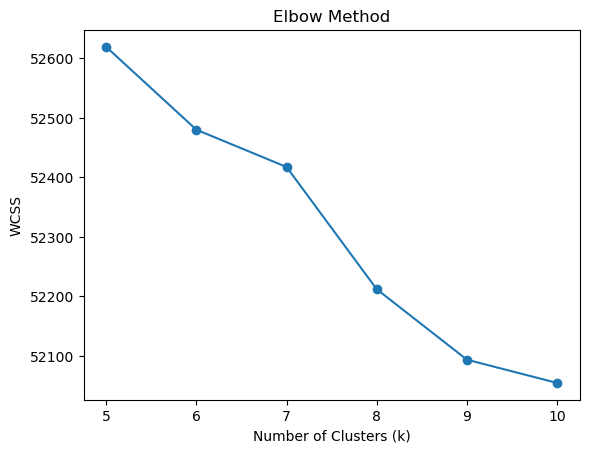

In [14]:
from tqdm import tqdm
from sklearn.cluster import KMeans

wcss = []
k_values = range(5, 11)

progress_bar = tqdm(total=len(k_values), desc='K-mean progress')
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(matrix.T)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value
    progress_bar.update(1)

# Plot the WCSS values
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.savefig('kmeans-elbow.png')
plt.show()

### Use the identified K for K-means

In [15]:
num_clusters = 9  # Specify the number of identified K clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(matrix.T)
cluster_labels = kmeans.labels_

df_label = pd.Series(cluster_labels,name='product cluster label')
df_kmean = pd.concat([unique_rows_series,df_label], axis=1)
df_kmean.columns = ['product_title', 'product cluster label']

/Users/linwang/opt/anaconda3/envs/py4ds/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualize clusters using wordcloud

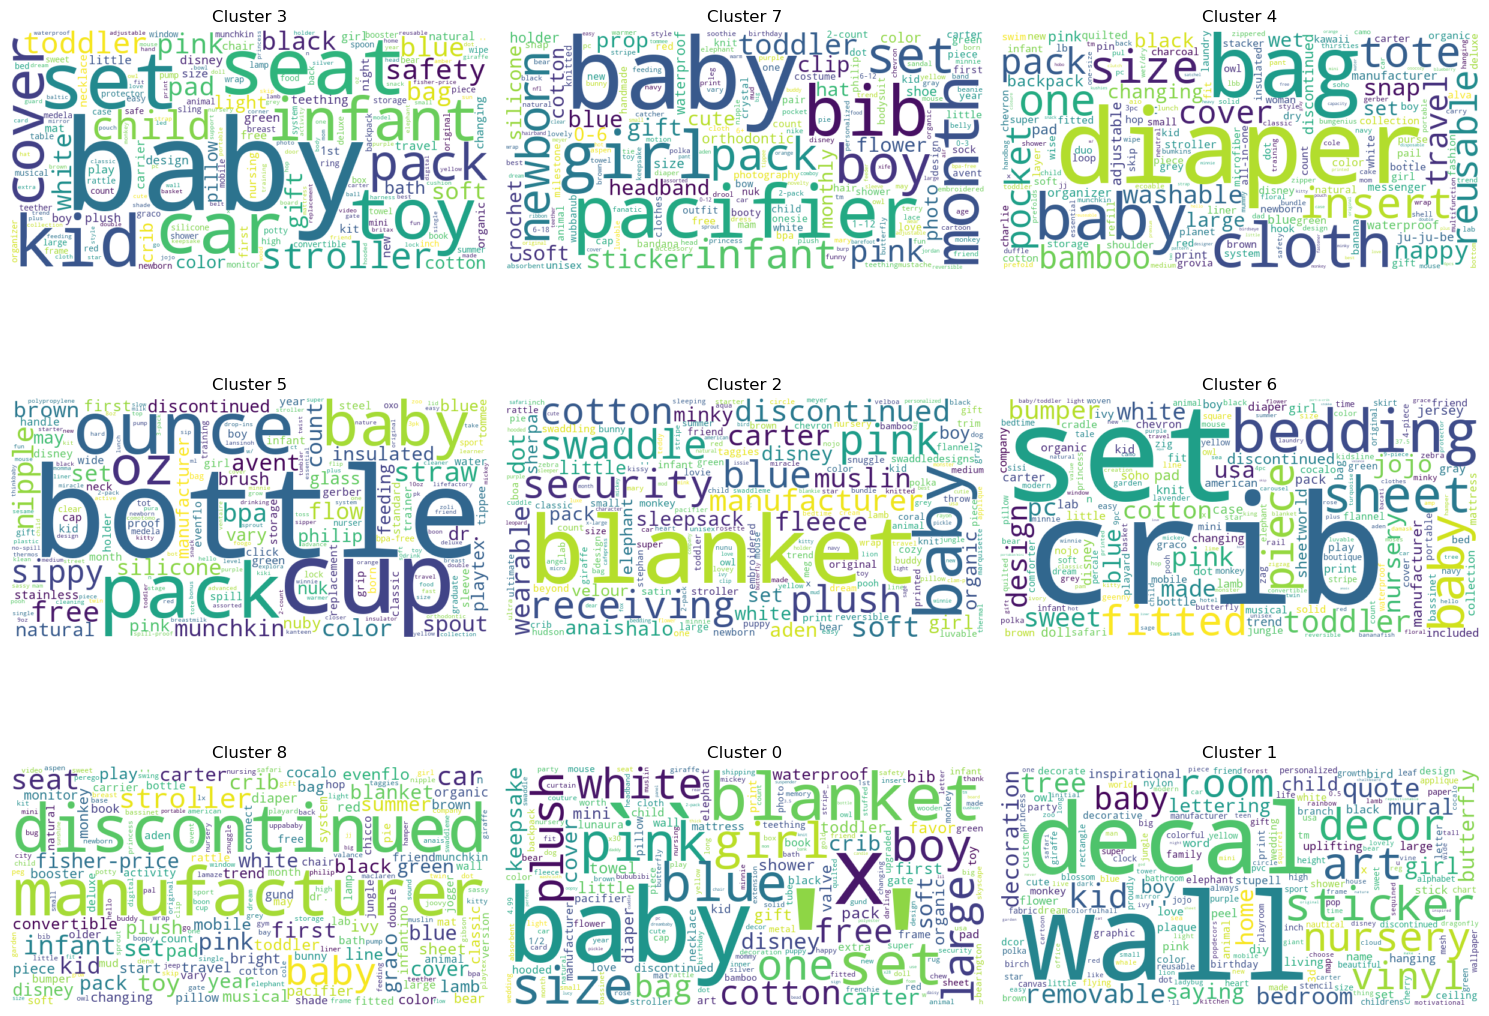

In [30]:
cluster_labels = df_kmean['product cluster label'].unique()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, cluster_label in enumerate(cluster_labels):
    df_text = df_kmean[df_kmean['product cluster label'] == cluster_label]['product_title']
    combined_text = ' '.join(df_text.astype(str))
    word_frequencies = Counter(combined_text.split())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_label}')
    ax.axis('off')

if len(cluster_labels) < len(axes):
    fig.delaxes(axes[len(cluster_labels)])

plt.tight_layout()
plt.savefig('kmeans-wordcloud.png')
plt.show()

### Assign cluster labels based on the plots

In [24]:
cluster_label = {
    0: 'blanket',
    1: 'decor',
    2: 'swaddle',
    3: 'seat',
    4: 'dipaer',
    5: 'bottle',
    6: 'crib',
    7: 'pacifier',
    8: 'discontinued'
}

df_kmean.loc[:,'cluster_label'] = df_kmean['product cluster label'].map(cluster_label)
df_kmean.head()

,product_title,product cluster label,cluster_label
0,summer infant swaddleme adjustable infant wrap...,3,seat
1,udder cover breast feeding nursing cover,3,seat
2,gerber graduate fun pack utensil,3,seat
3,summer infant ultra sight pan/scan/zoom video ...,3,seat
4,summer infant keep clean disposable bib 20-count,7,pacifier


## Combine cluster labels with other information

In [29]:
df_final = df.merge(df_kmean, on='product_title', how='left')
df_final.to_csv(df_path+'processed/data_clean_kmeanlabel.csv',index=False)
df_final.head()

,customer_id,review_id,product_id,review_date,star_rating,raw_product_title,raw_review_headline,raw_review_body,product_title,review_headline,review_body,product cluster label,cluster_label
0,9970739,R8EWA1OFT84NX,B00GSP5D94,2015-08-31,5,Summer Infant SwaddleMe Adjustable Infant Wrap...,Great swaddled blankets,Loved these swaddle blankets and so did my dau...,summer infant swaddleme adjustable infant wrap...,great swaddled blanket,loved swaddle blanket daughter slept much bett...,3,seat
1,8273344,RL5ESX231LZ0B,B00BUBNZC8,2015-08-31,5,Udder Covers - Breast Feeding Nursing Cover,Five Stars,Great gift,udder cover breast feeding nursing cover,five star,great gift,3,seat
2,24557753,RRMS9ZWJ2KD08,B00AWLZFTS,2015-08-31,5,Gerber Graduates Fun Pack Utensils,Cute; wash up nicely in dishwasher.,These forks are great for my 10 month old daug...,gerber graduate fun pack utensil,cute wash nicely dishwasher,fork great month old daughter wanted find nice...,3,seat
3,46263340,R14I3ZG5E6S7YM,B00KM60D3Q,2015-08-31,5,Summer Infant Ultra Sight Pan/Scan/Zoom Video ...,Love it!,I wanted something for piece of mind with my l...,summer infant ultra sight pan/scan/zoom video ...,love,wanted something piece mind little one wanted ...,3,seat
4,24557753,R13EPSFP5DODN5,B00PQMRZG4,2015-08-31,4,"Summer Infant Keep Me Clean Disposable Bibs, 2...",Rips easily.,Loved with daughter about 4-6 months. After th...,summer infant keep clean disposable bib 20-count,rip easily,loved daughter 4-6 month child realize easily ...,7,pacifier
